In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from pyod.models.gmm import GMM
from sklearn.metrics import (precision_recall_curve, roc_curve, roc_auc_score,
                             accuracy_score, precision_score, recall_score, f1_score)
from pyod.models.auto_encoder import AutoEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
data_scaled = pd.read_csv("scaled_training_dataset.csv")
data_test_scaled = pd.read_csv("scaled_test_dataset.csv")
data=pd.read_csv("data.csv")

This approach is used to determine the optimal number of clusters for the Gaussian Mixture Model (GMM) by evaluating different cluster counts and selecting the one that provides the best fit for the data, as indicated by the BIC and AIC scores.
In this approach, lower AIC  and BIC scores indicate a better model. 

In [12]:
def find_best_gmm_components(data_scaled, selected_features_clusters, max_components=10):
    data_features = data_scaled[selected_features_clusters].copy()
    bics = []
    aics = []
    
    for n in range(1, max_components + 1):
        gmm = GaussianMixture(n_components=n, random_state=42)
        gmm.fit(data_features)
        bics.append(gmm.bic(data_features))
        aics.append(gmm.aic(data_features))
    
    return bics, aics


Starting with features that provide insights into cardholder behavior, the most important ones  selected using Random Forest and SelectKBest are 'amt','amt_rolling_mean_7d','amt_rolling_mean_15d','avg_daily_trans','num_trans_per_card',
'category_diversity','age_spend_ratio' and i added the distance_between_cardholder_merchant to have more insights 


## Finding best number of components for card features 

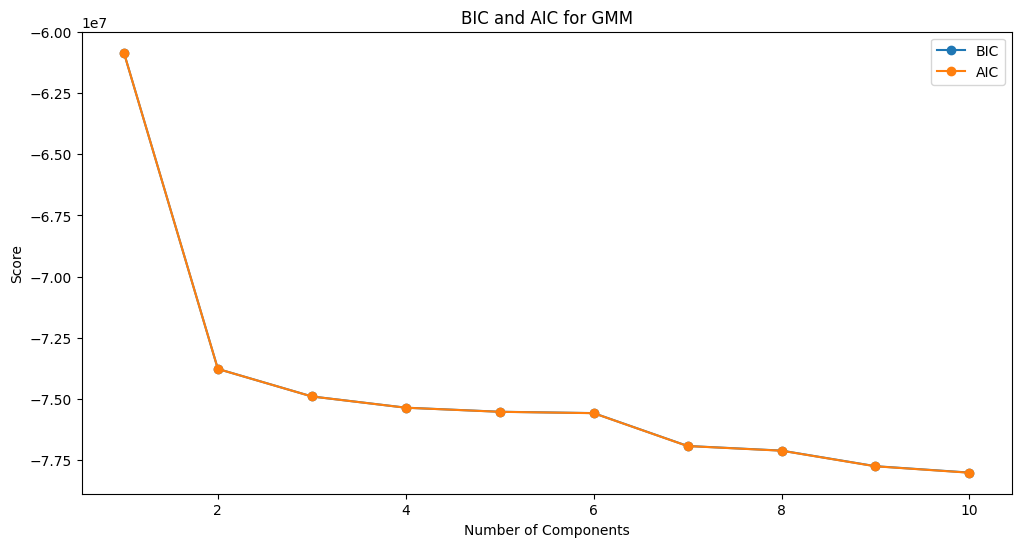

In [14]:
card_features = [
    'amt','amt_rolling_mean_7d','amt_rolling_mean_15d','avg_daily_trans','num_trans_per_card',
    'distance_between_cardholder_merchant','category_diversity','age_spend_ratio'
]
bics, aics = find_best_gmm_components(data_scaled,card_features, max_components=10)
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), bics, label='BIC', marker='o')
plt.plot(range(1, 11), aics, label='AIC', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('BIC and AIC for GMM')
plt.legend()
plt.show()


## Finding best number of components for merchant features

In [3]:
merchant_features = [
   'distance_between_cardholder_merchant','merchant_amt_rolling_mean_7d', 
    'merchant_amt_rolling_mean_15d', 
    'unique_clients_count'
]
bics, aics = find_best_gmm_components(data_scaled,merchant_features, max_components=10)
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), bics, label='BIC', marker='o')
plt.plot(range(1, 11), aics, label='AIC', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('BIC and AIC for GMM')
plt.legend()
plt.show()


## Applying GMM on card features 



**1. Clustering and Anomaly Detection:**

We start by analyzing historical data to understand typical spending patterns for credit card transactions. Using these patterns, we fit a model (Gaussian Mixture Model) to identify what normal transactions look like. Then, we apply this model to new transactions to determine if they deviate from the norm, which might indicate suspicious or fraudulent activity.

**2. Finding the Best Threshold:**

To decide what constitutes suspicious activity, we need to set a threshold. This threshold helps us classify transactions as either normal or potentially fraudulent based on their anomaly scores. We find the best threshold by looking at various options and choosing the one that gives the best balance between detecting fraud and minimizing false alarms. This involves plotting graphs and calculating key performance metrics.

**3. Analyzing Results:**

With the best threshold in hand, we re-evaluate the transactions. We then categorize transactions into potential anomalies and non-anomalies. This helps us pinpoint which transactions might be fraudulent and which are normal, making it easier to investigate suspicious activities further.

---

This approach ensures that we can effectively spot unusual transactions and act on them while minimizing false positives.

In [5]:
def cluster_and_detect_anomalies(data_train, data_test, selected_features, target='is_fraud', n_components=2, index_col='cc_num'):
    """
    Analyzes transaction data to detect anomalies by clustering transactions into different groups.

    1. **Prepare Data**: Uses the training data to understand what normal transactions look like.
    2. **Fit Model**: Fits a Gaussian Mixture Model (GMM) to the training data to capture normal patterns.
    3. **Detect Anomalies**: Applies this model to the test data to identify transactions that deviate from the norm.
    4. **Output**: Returns a DataFrame with each transaction's anomaly score, which indicates how unusual it is compared to normal transactions.

    Parameters:
    - data_train: DataFrame containing the training data.
    - data_test: DataFrame containing the test data.
    - selected_features: List of feature names used for clustering.
    - target: Name of the target column indicating fraudulent transactions.
    - n_components: Number of clusters (components) for the GMM.
    - index_col: Column to set as the index of the DataFrames (e.g., credit card number).

    Returns:
    - DataFrame with transaction features, anomaly scores, and probabilities.
    """
    if index_col:
        data_train.set_index(index_col, inplace=True)
        data_test.set_index(index_col, inplace=True)

    X_train = data_train[selected_features].values
    y_train = data_train[target]
    X_test = data_test[selected_features].values
    y_test = data_test[target]
    
    gmm = GMM(n_components=n_components, random_state=42)
    gmm.fit(X_train)
    
    probabilities = gmm.predict_proba(X_test)
    
    result_df = pd.DataFrame(X_test, columns=selected_features, index=data_test.index)
    result_df[target] = y_test
    result_df['max_prob'] = np.max(probabilities, axis=1)
    result_df['anomaly_score'] = np.min(probabilities, axis=1)
    
    return result_df

def find_best_threshold(data_df, target='is_fraud'):
    """
    Determines the best threshold for classifying transactions as fraudulent based on anomaly scores.

    1. **Calculate Scores**: Computes precision, recall, and F1 scores for various thresholds using anomaly scores.
    2. **Optimize Threshold**: Finds the threshold that gives the best balance between precision and recall.
    3. **Evaluate Performance**: Computes and prints key performance metrics such as accuracy, precision, recall, and AUC.
    4. **Plot Results**: Displays plots to visualize the relationship between thresholds and F1 score, as well as the ROC curve.

    Parameters:
    - data_df: DataFrame containing the anomaly scores and true labels.
    - target: Name of the target column indicating fraudulent transactions.

    Returns:
    - Best threshold value for classifying anomalies.
    """
    y_true = data_df[target]
    y_scores = data_df['anomaly_score']
    
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    
    y_pred = (y_scores > best_threshold).astype(int)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision_best = precision_score(y_true, y_pred)
    recall_best = recall_score(y_true, y_pred)
    actual_fraud = np.sum(y_true)
    predicted_fraud = np.sum(y_pred)

    print(f"Best Threshold: {best_threshold:.4f}")
    print(f"Best F1-Score: {f1_scores[best_idx]:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision_best:.4f}")
    print(f"Recall: {recall_best:.4f}")
    print(f"F1-Score: {f1_scores[best_idx]:.4f}")
    print(f"Actual fraud cases: {actual_fraud}")
    print(f"Predicted fraud cases: {predicted_fraud}")

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
    plt.axvline(x=best_threshold, color='red', linestyle='--', label='Best Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Threshold')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    
    plt.tight_layout()
    plt.show()

    return best_threshold

def GMM_analysis_to_df(data_train, data_test, selected_features, n_components=3, threshold=0.02, index_col='cc_num'):
    """
    Analyzes transaction data to identify potential frauds using a fixed threshold.

    1. **Run Anomaly Detection**: Applies the clustering model to detect anomalies in the test data.
    2. **Apply Threshold**: Classifies transactions as potential anomalies based on a pre-defined threshold.
    3. **Separate Data**: Splits the data into transactions classified as anomalies and those classified as normal.

    Parameters:
    - data_train: DataFrame containing the training data.
    - data_test: DataFrame containing the test data.
    - selected_features: List of feature names used for clustering.
    - n_components: Number of clusters for the GMM.
    - threshold: Fixed threshold for identifying potential anomalies.
    - index_col: Column to set as the index of the DataFrames (e.g., credit card number).

    Returns:
    - result_df: DataFrame with all transactions including their anomaly scores and classifications.
    - anomalies_df: DataFrame with transactions classified as anomalies.
    - non_anomalies_df: DataFrame with transactions classified as normal.
    """
    if not (0 <= threshold <= 1):
        raise ValueError("Threshold must be between 0 and 1.")
    
    result_df = cluster_and_detect_anomalies(
        data_train,
        data_test,
        selected_features=selected_features,
        n_components=n_components,
        index_col=index_col
    )

    result_df['potential_anomaly'] = result_df['anomaly_score'] > threshold

    anomalies_df = result_df[result_df['potential_anomaly']]
    non_anomalies_df = result_df[~result_df['potential_anomaly']]

    return result_df, anomalies_df, non_anomalies_df


Best Threshold: 0.0289
Best F1-Score: 0.2667
AUC: 0.9514
Accuracy: 0.9912
Precision: 0.1958
Recall: 0.4169
F1-Score: 0.2667
Actual fraud cases: 2125
Predicted fraud cases: 4525


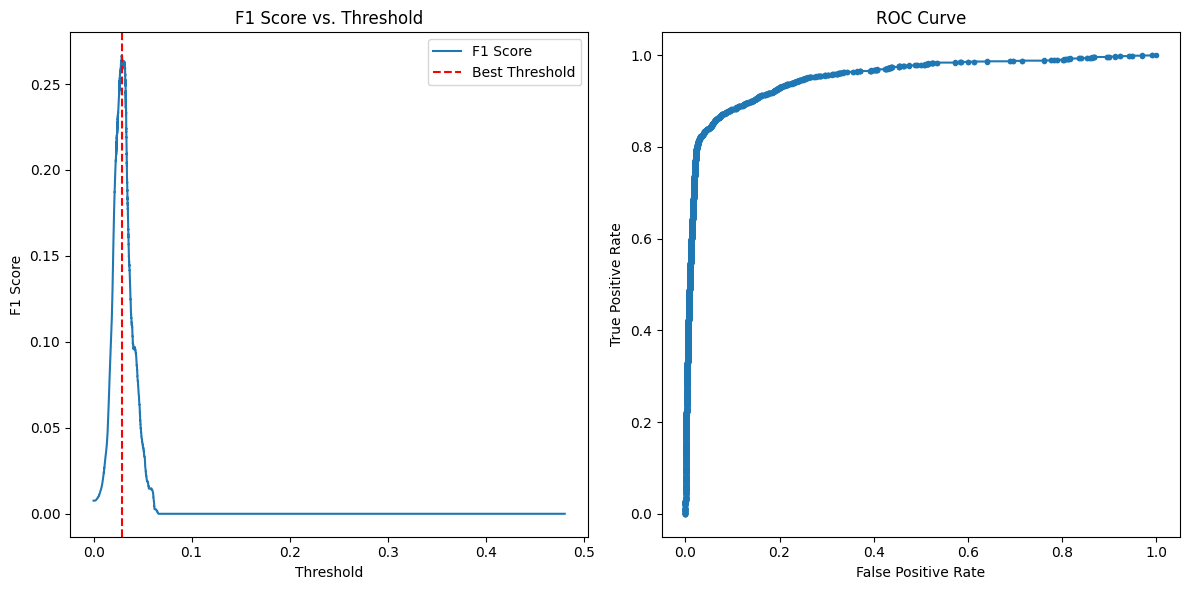

,max_prob,anomaly_score,potential_anomaly,is_fraud
cc_num,,,,
60487002085,0.977721,0.022279,True,1
60487002085,0.978785,0.021215,True,1
60487002085,0.966695,0.033305,True,1
60487002085,0.966353,0.033647,True,1
60487002085,0.966701,0.033299,True,1
60487002085,0.966413,0.033587,True,1
60487002085,0.965975,0.034025,True,1
60487002085,0.965633,0.034367,True,1
60495593109,0.977872,0.022128,True,1


In [6]:
data_train = data_scaled[card_features + ['cc_num', 'is_fraud']].copy()
data_test_scaled_filtered = data_test_scaled[card_features + ['cc_num', 'is_fraud']].copy()

result_df, anomalies_df, non_anomalies_df = GMM_analysis_to_df(
    data_train=data_train,
    data_test=data_test_scaled_filtered,
    selected_features=card_features,
    n_components=3,
    threshold=0.02,
    index_col='cc_num'
)

selected_columns = ['max_prob', 'anomaly_score', 'potential_anomaly', 'is_fraud']
filtered_df = result_df[result_df['is_fraud'] == 1][selected_columns]
best_threshold = find_best_threshold(result_df, target='is_fraud')
filtered_df.head(50)



Confusion Matrix:


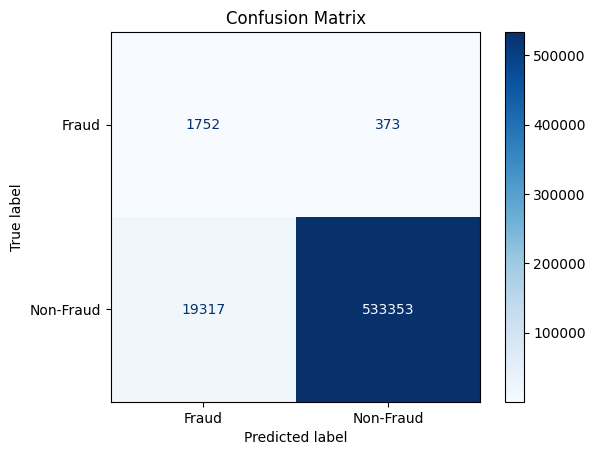

In [7]:
def plot_confusion_matrix(y_true, y_pred, labels=['Fraud', 'Non-Fraud']):
    """
    Computes and plots the confusion matrix.

    Parameters:
    - y_true: Array-like, true labels of the test data.
    - y_pred: Array-like, predicted labels of the test data.
    - labels: List of class labels.

    Returns:
    - None
    """
    confusion_mat = confusion_matrix(y_true, y_pred, labels=[1, 0])
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=labels)
    print("Confusion Matrix:")
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

y_true = result_df['is_fraud']
y_pred = result_df['potential_anomaly'].astype(int)

plot_confusion_matrix(y_true, y_pred, labels=['Fraud', 'Non-Fraud'])


## Applying GMM with merchant features 

Best Threshold: 0.0139
Best F1-Score: 0.0221
AUC: 0.7231
Accuracy: 0.9715
Precision: 0.0126
Recall: 0.0833
F1-Score: 0.0221
Actual fraud cases: 2125
Predicted fraud cases: 14017


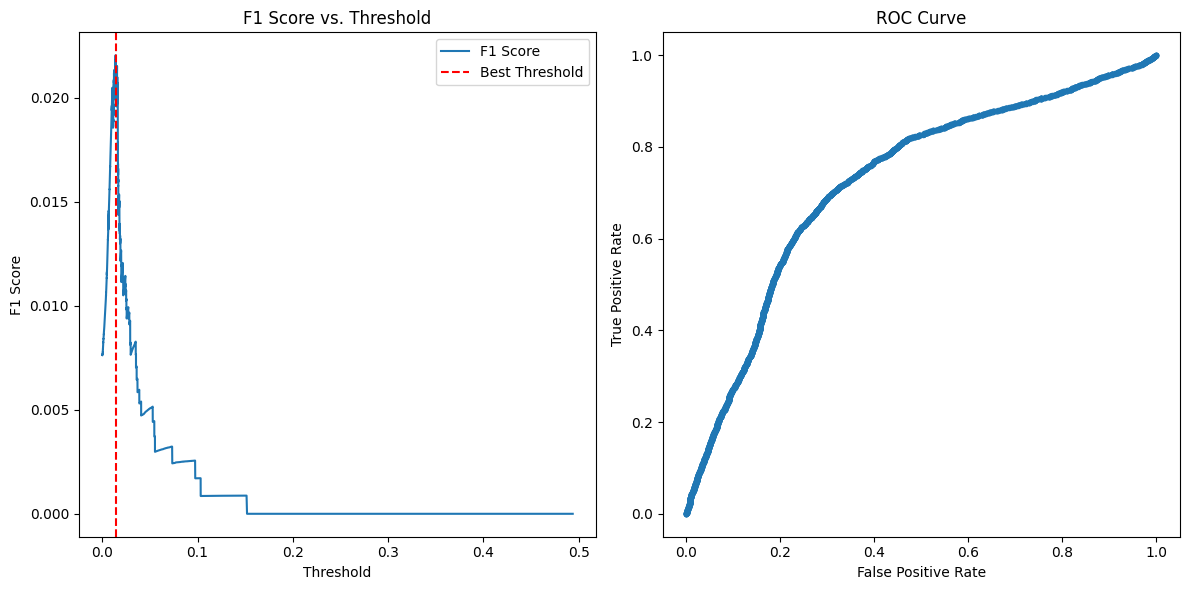

,max_prob,anomaly_score,potential_anomaly,is_fraud
cc_num,,,,
60487002085,0.990798,0.009202,False,1
60487002085,0.989985,0.010015,False,1
60487002085,0.989141,0.010859,False,1
60487002085,0.987060,0.012940,False,1
60487002085,0.989943,0.010057,False,1
60487002085,0.988744,0.011256,False,1
60487002085,0.999216,0.000784,False,1
60487002085,0.988964,0.011036,False,1
60495593109,0.993130,0.006870,False,1


In [8]:
data_train = data_scaled[merchant_features + ['cc_num', 'is_fraud']].copy()
data_test_scaled_filtered = data_test_scaled[merchant_features+ ['cc_num', 'is_fraud']].copy()

result_df, anomalies_df, non_anomalies_df = GMM_analysis_to_df(
    data_train=data_train,
    data_test=data_test_scaled_filtered,
    selected_features=merchant_features,
    n_components=3,
    threshold=0.0152,
    index_col='cc_num'
)

selected_columns = ['max_prob', 'anomaly_score', 'potential_anomaly', 'is_fraud']
filtered_df = result_df[result_df['is_fraud'] == 1][selected_columns]
best_threshold = find_best_threshold(result_df, target='is_fraud')
filtered_df.head(50)


## Applying autoencoder  on card features

In [13]:
def autoencoder_anomaly_detection(data_train, data_test, selected_features, target='is_fraud', contamination=0.006, fixed_threshold=None):
    """
    Applies an AutoEncoder model to detect anomalies in the data and evaluates its performance.

    Parameters:
    - data_train: DataFrame containing the training data.
    - data_test: DataFrame containing the test data.
    - selected_features: List of feature names used for anomaly detection.
    - target: Name of the target column indicating fraudulent transactions.
    - contamination: Proportion of anomalies in the data.
    - fixed_threshold: Optional fixed threshold for anomaly detection.

    Returns:
    - DataFrame with transaction features, MSE (anomaly_score_autoencoder), and potential anomalies.
    """
    
    X_train = data_train[selected_features].values
    X_test = data_test[selected_features].values
    y_test = data_test[target] 

    autoencoder = AutoEncoder(contamination=contamination, random_state=42)
    autoencoder.fit(X_train)
    
    anomaly_scores_autoencoder = autoencoder.decision_function(X_test)
    
    result_df_autoencoder = pd.DataFrame(X_test, columns=selected_features, index=data_test.index)
    result_df_autoencoder['anomaly_score_autoencoder'] = anomaly_scores_autoencoder
    
    result_df_autoencoder.rename(columns={'anomaly_score_autoencoder': 'anomaly_score'}, inplace=True)
    
    if fixed_threshold is None:
        threshold = autoencoder.threshold_
    else:
       
        threshold = fixed_threshold
    
    result_df_autoencoder['potential_anomaly'] = result_df_autoencoder['anomaly_score'] > threshold
    
    result_df_autoencoder[target] = y_test

    print(f"Threshold used for AutoEncoder: {threshold:.4f}")
    
    return result_df_autoencoder, threshold


Training: 100%|██████████| 10/10 [44:05<00:00, 264.56s/it]


Best Threshold: 2.6056
Best F1-Score: 0.2889
AUC: 0.9511
Accuracy: 0.9944
Precision: 0.2823
Recall: 0.2951
F1-Score: 0.2889
Actual fraud cases: 2125
Predicted fraud cases: 2221


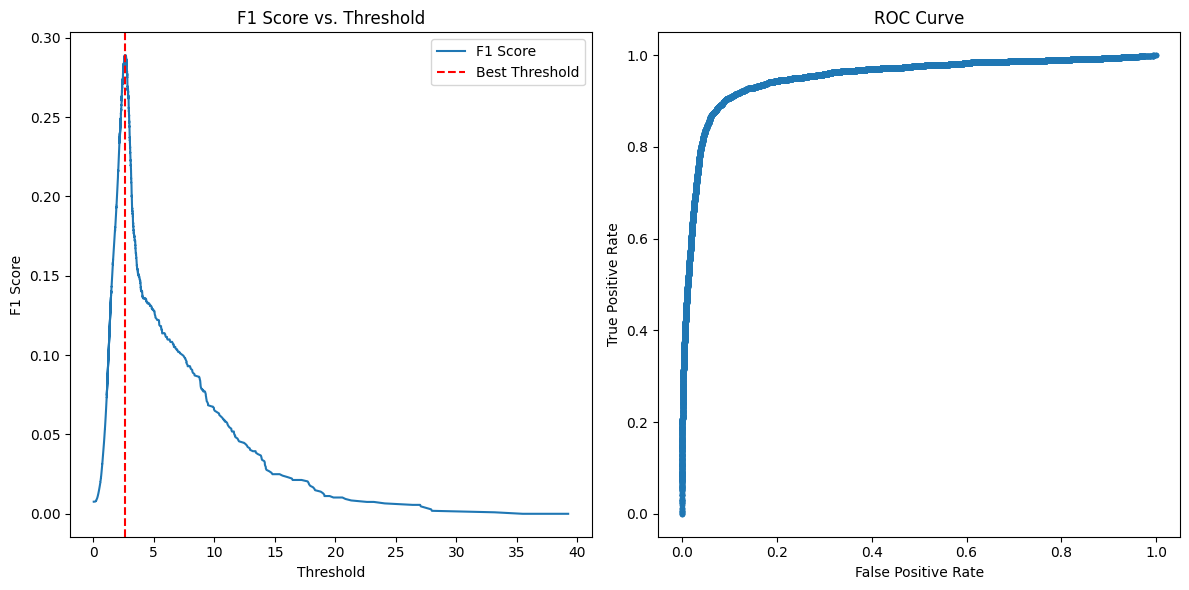

Best Threshold for AutoEncoder: 2.6056
Confusion Matrix:


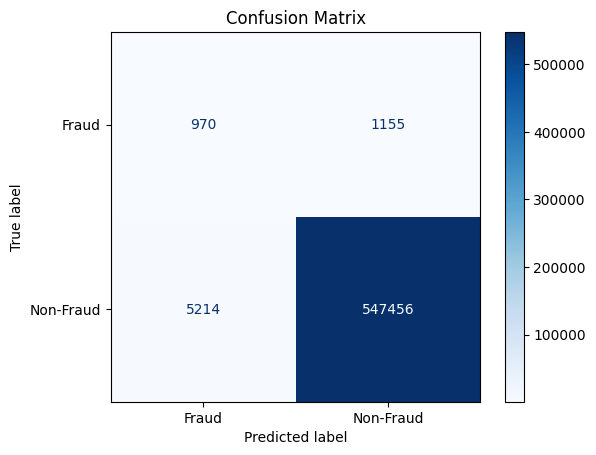

In [12]:
data_train = data_scaled[card_features + ['cc_num', 'is_fraud']].copy()
data_test_scaled_filtered = data_test_scaled[card_features + ['cc_num', 'is_fraud']].copy()

result_df_autoencoder, best_threshold = autoencoder_anomaly_detection(
    data_train=data_train,
    data_test=data_test_scaled_filtered,
    selected_features=card_features,
    target='is_fraud',
    contamination=0.006,
)

y_true = result_df_autoencoder['is_fraud']
y_pred = result_df_autoencoder['potential_anomaly'].astype(int)

plot_confusion_matrix(y_true, y_pred, labels=['Fraud', 'Non-Fraud'])


Observation: The GMM predicts more fraud cases compared to the Autoencoder. This suggests that GMM is more aggressive in detecting anomalies, potentially leading to more false positives.

## Applying autoencoder on merchant features

Training: 100%|██████████| 10/10 [39:07<00:00, 234.79s/it]


Threshold used for AutoEncoder: 0.5000
Confusion Matrix:


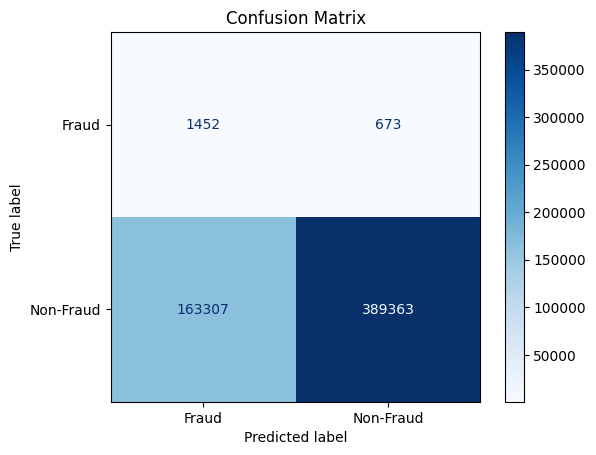

In [14]:
data_train = data_scaled[merchant_features + ['cc_num', 'is_fraud']].copy()
data_test_scaled_filtered = data_test_scaled[merchant_features+ ['cc_num', 'is_fraud']].copy()
fixed_threshold_value = 0.5 

result_df_autoencoder, threshold = autoencoder_anomaly_detection(
    data_train=data_train,
    data_test=data_test_scaled_filtered,
    selected_features=merchant_features,
    target='is_fraud',
    contamination=0.006,
    fixed_threshold=fixed_threshold_value
)

y_true = result_df_autoencoder['is_fraud']
y_pred = result_df_autoencoder['potential_anomaly'].astype(int)

plot_confusion_matrix(y_true, y_pred, labels=['Fraud', 'Non-Fraud'])

## Applying autoencoder with gmm

By using the GMM anomaly scores as features for the AutoEncoder, the model leverages the GMM’s initial anomaly detection and refines it with the AutoEncoder’s capacity to detect complex patterns. This combination can lead to better detection of subtle anomalies that GMM alone might miss.

In [10]:
def find_best_threshold(y_true, y_scores, thresholds):
    """
    Finds the best threshold based on F1-Score.

    Parameters:
    - y_true: Array-like, ground truth (true labels).
    - y_scores: Array-like, predicted scores or probabilities.
    - thresholds: Array-like, thresholds to evaluate.

    Returns:
    - best_threshold: The threshold that yields the highest F1-Score.
    - best_f1: The best F1-Score.
    """
    best_threshold = thresholds[0]
    best_f1 = 0

    for threshold in thresholds:
        y_pred = (y_scores > threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

def autoencoder_on_gmm_anomalies(result_df_gmm, selected_features, contamination=0.006, search_best_threshold=True):
    """
    Applies an AutoEncoder model to the GMM anomaly scores to detect anomalies and evaluate the performance.
    
    Parameters:
    - result_df_gmm: DataFrame containing GMM results with anomaly scores.
    - selected_features: List of feature names used for anomaly detection, excluding 'is_fraud'.
    - contamination: Proportion of anomalies in the data.
    - search_best_threshold: Whether to search for the best threshold or use the model's threshold.
    
    Returns:
    - DataFrame with anomaly scores from AutoEncoder and potential anomalies, sorted by anomaly score.
    - The threshold used for anomaly detection.
    """
    if result_df_gmm.index.name is None:
        raise ValueError("Index column must be set in the DataFrame.")
    
    X_gmm_results = result_df_gmm[selected_features].values
    
    autoencoder_gmm = AutoEncoder(contamination=contamination, random_state=42)
    autoencoder_gmm.fit(X_gmm_results)
    
    anomaly_scores_autoencoder = autoencoder_gmm.decision_function(X_gmm_results)
    
    result_df_autoencoder = result_df_gmm.copy()
    result_df_autoencoder['anomaly_score_autoencoder'] = anomaly_scores_autoencoder
    
    if search_best_threshold:
        thresholds = np.linspace(0, 1, 100) 
        best_threshold, best_f1 = find_best_threshold(result_df_autoencoder['is_fraud'], anomaly_scores_autoencoder, thresholds)
        print(f"Best Threshold: {best_threshold:.4f}, Best F1-Score: {best_f1:.4f}")
    else:
        best_threshold = autoencoder_gmm.threshold_
    
    result_df_autoencoder['potential_anomaly_autoencoder'] = result_df_autoencoder['anomaly_score_autoencoder'] > best_threshold
    
    result_df_autoencoder_sorted = result_df_autoencoder.sort_values(by='anomaly_score_autoencoder', ascending=False)
    
    y_true = result_df_autoencoder['is_fraud']
    y_pred = result_df_autoencoder['potential_anomaly_autoencoder'].astype(int)  
    
    auc = roc_auc_score(y_true, anomaly_scores_autoencoder)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    print(f"AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    fpr, tpr, _ = roc_curve(y_true, anomaly_scores_autoencoder)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[1, 0])  
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Fraud', 'Non-Fraud'])
    disp.plot(cmap='Blues')
    plt.show()
    
    return result_df_autoencoder_sorted, best_threshold



Training: 100%|██████████| 10/10 [12:28<00:00, 74.80s/it]


Best Threshold: 1.0000, Best F1-Score: 0.0904
AUC: 0.9558
Accuracy: 0.9303
Precision: 0.0476
Recall: 0.9049
F1-Score: 0.0904


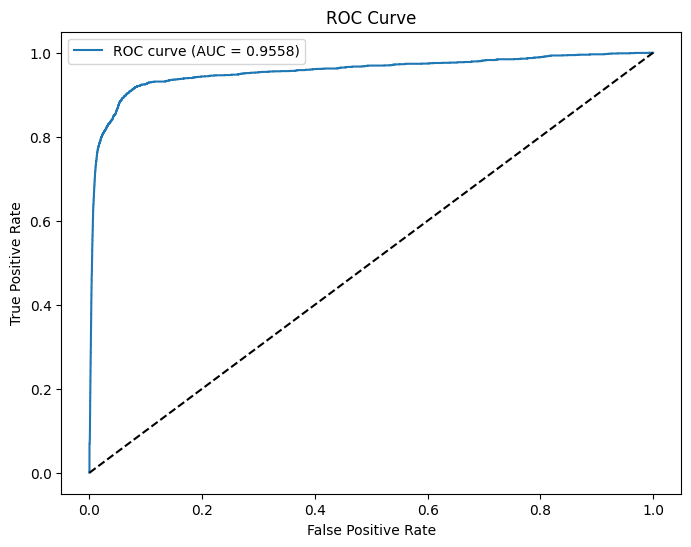

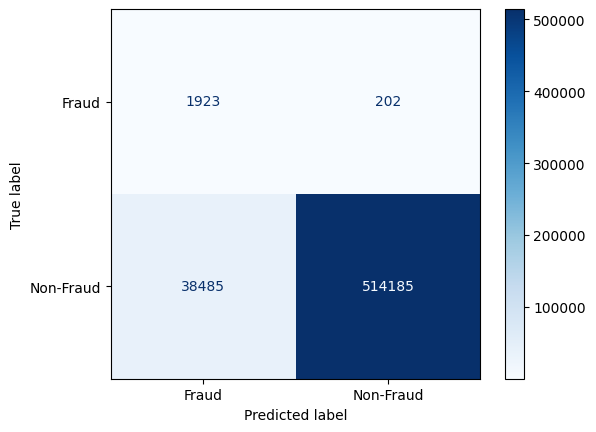

Threshold Used: 1.0000


,amt,amt_rolling_mean_7d,amt_rolling_mean_15d,avg_daily_trans,num_trans_per_card,distance_between_cardholder_merchant,category_diversity,age_spend_ratio,is_fraud,max_prob,anomaly_score,potential_anomaly,anomaly_score_autoencoder,potential_anomaly_autoencoder
cc_num,,,,,,,,,,,,,,
4497913965512794052,0.850521,0.848376,0.846033,0.276302,0.285422,0.743675,1.000000,0.933529,0,1.000000,0.000000,False,96.775032,True
4417677808209716,0.041844,0.262017,0.467257,0.009659,0.003406,0.137177,0.000000,0.041844,1,0.943824,0.056176,True,41.478615,True
4417677808209716,0.012136,0.167583,0.351892,0.009659,0.003406,0.311002,0.000000,0.012136,1,0.947561,0.052439,True,40.441017,True
4417677808209716,0.014734,0.162859,0.341973,0.009659,0.003406,0.173757,0.000000,0.014734,1,0.946475,0.053525,True,40.422047,True
4417677808209716,0.044625,0.184359,0.387117,0.009659,0.003406,0.075888,0.000000,0.044625,1,0.944547,0.055453,True,39.407631,True
4417677808209716,0.051285,0.261542,0.453312,0.009659,0.003406,0.577655,0.000000,0.051285,1,0.945972,0.054028,True,39.297451,True
4417677808209716,0.041362,0.153411,0.322132,0.009659,0.003406,0.242856,0.000000,0.041362,1,0.946993,0.053007,True,38.501514,True
4417677808209716,0.036207,0.211278,0.421050,0.009659,0.003406,0.697813,0.000000,0.036207,1,0.946683,0.053317,True,38.304897,True
4417677808209716,0.041844,0.190087,0.408064,0.009659,0.003406,0.643127,0.000000,0.041844,1,0.947040,0.052960,True,37.763500,True


In [11]:
result_df_autoencoder_from_gmm, threshold_used = autoencoder_on_gmm_anomalies(
    result_df_gmm=result_df,
    selected_features=[feature for feature in result_df.columns if feature not in ['is_fraud']],  
    contamination=0.006,
    search_best_threshold=True  
)
print(f"Threshold Used: {threshold_used:.4f}")
result_df_autoencoder_from_gmm.head(20)


## Historical transactions of anomalous credit card numbers

In [12]:

def analyze_anomalous_transactions(result_df, data, n_samples=10):
    """
    Analyze historical transactions of anomalous credit card numbers.

    Parameters:
    - result_df: DataFrame containing results from anomaly detection, including potential anomalies.
    - data: Original dataset containing transaction details.
    - n_samples: Number of anomalous credit card numbers to analyze and visualize.
    """
    anomalous_cc_nums = result_df[result_df['potential_anomaly'] == True].index.unique()
    
    historical_transactions = data[(data['cc_num'].isin(anomalous_cc_nums)) & (data['is_fraud'] == 1)]
    
    grouped_historical_transactions = historical_transactions.groupby('cc_num')
    
    for i, (cc_num, transactions) in enumerate(grouped_historical_transactions):
        if i >= n_samples:
            break
        
        plt.figure(figsize=(14, 10))
        
        plt.subplot(3, 1, 1)
        plt.hist(transactions['hour_of_day'], bins=24, color='b', alpha=0.7)
        plt.xlabel('Hour of Day')
        plt.ylabel('Frequency')
        plt.title(f'Fraudulent Transactions - Hour of Day for Anomalous CC Number {cc_num}')
        
        plt.subplot(3, 1, 2)
        plt.hist(transactions['day_of_week'], bins=7, color='r', alpha=0.7)
        plt.xlabel('Day of Week')
        plt.ylabel('Frequency')
        plt.title(f'Fraudulent Transactions - Day of Week for Anomalous CC Number {cc_num}')
        
        plt.subplot(3, 1, 3)
        plt.hist(transactions['time_since_last_transaction'], bins=20, color='g', alpha=0.7)
        plt.xlabel('Time Since Last Transaction (seconds)')
        plt.ylabel('Frequency')
        plt.title(f'Fraudulent Transactions - Time Since Last Transaction for Anomalous CC Number {cc_num}')
        
        plt.tight_layout()
        plt.show()


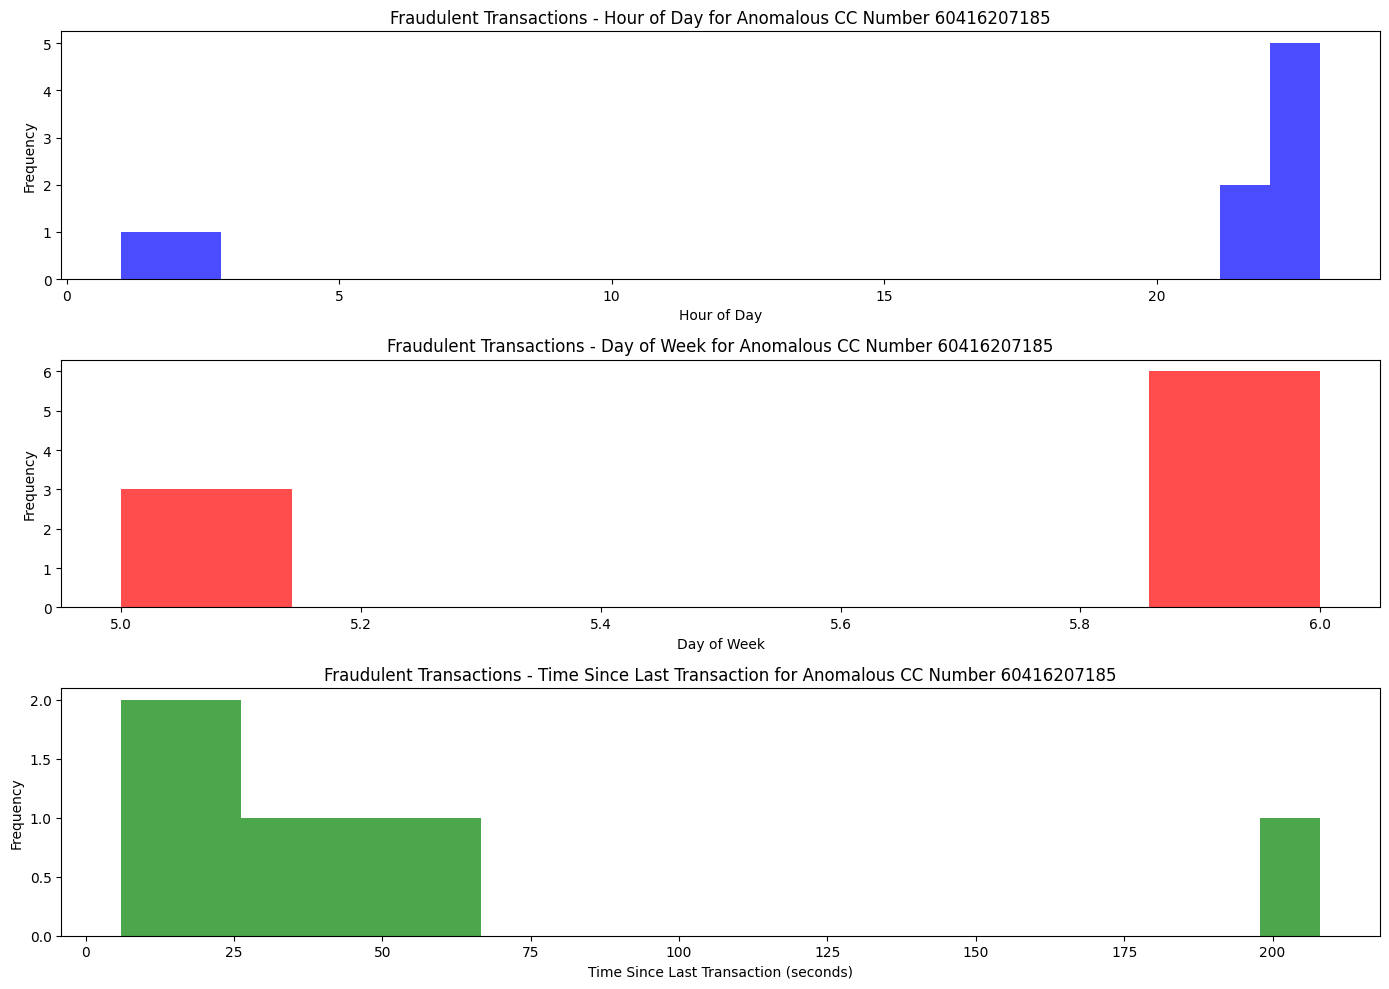

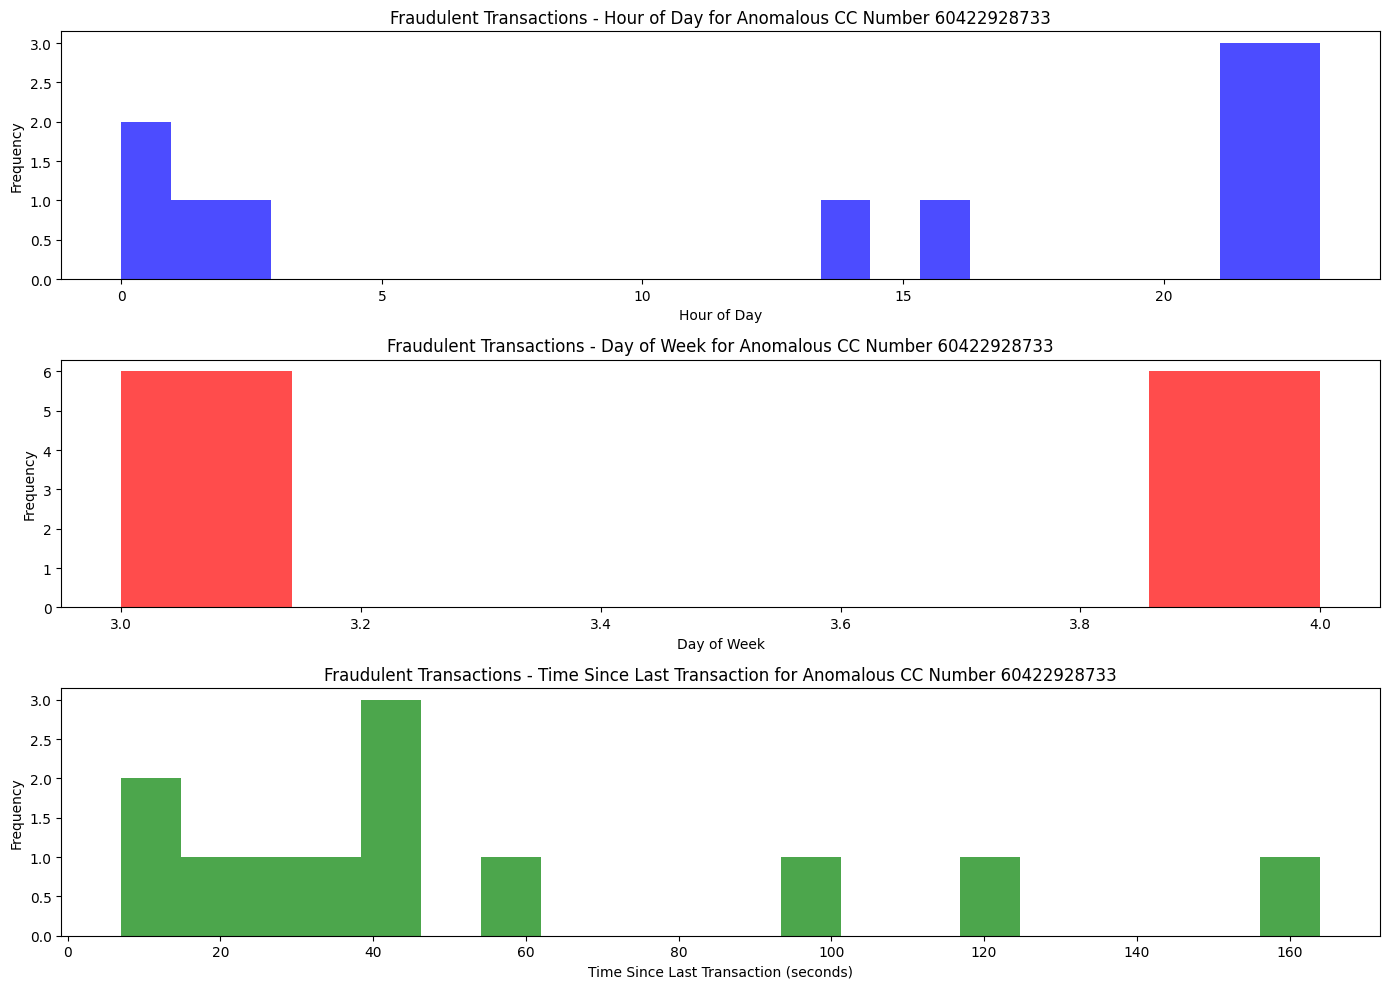

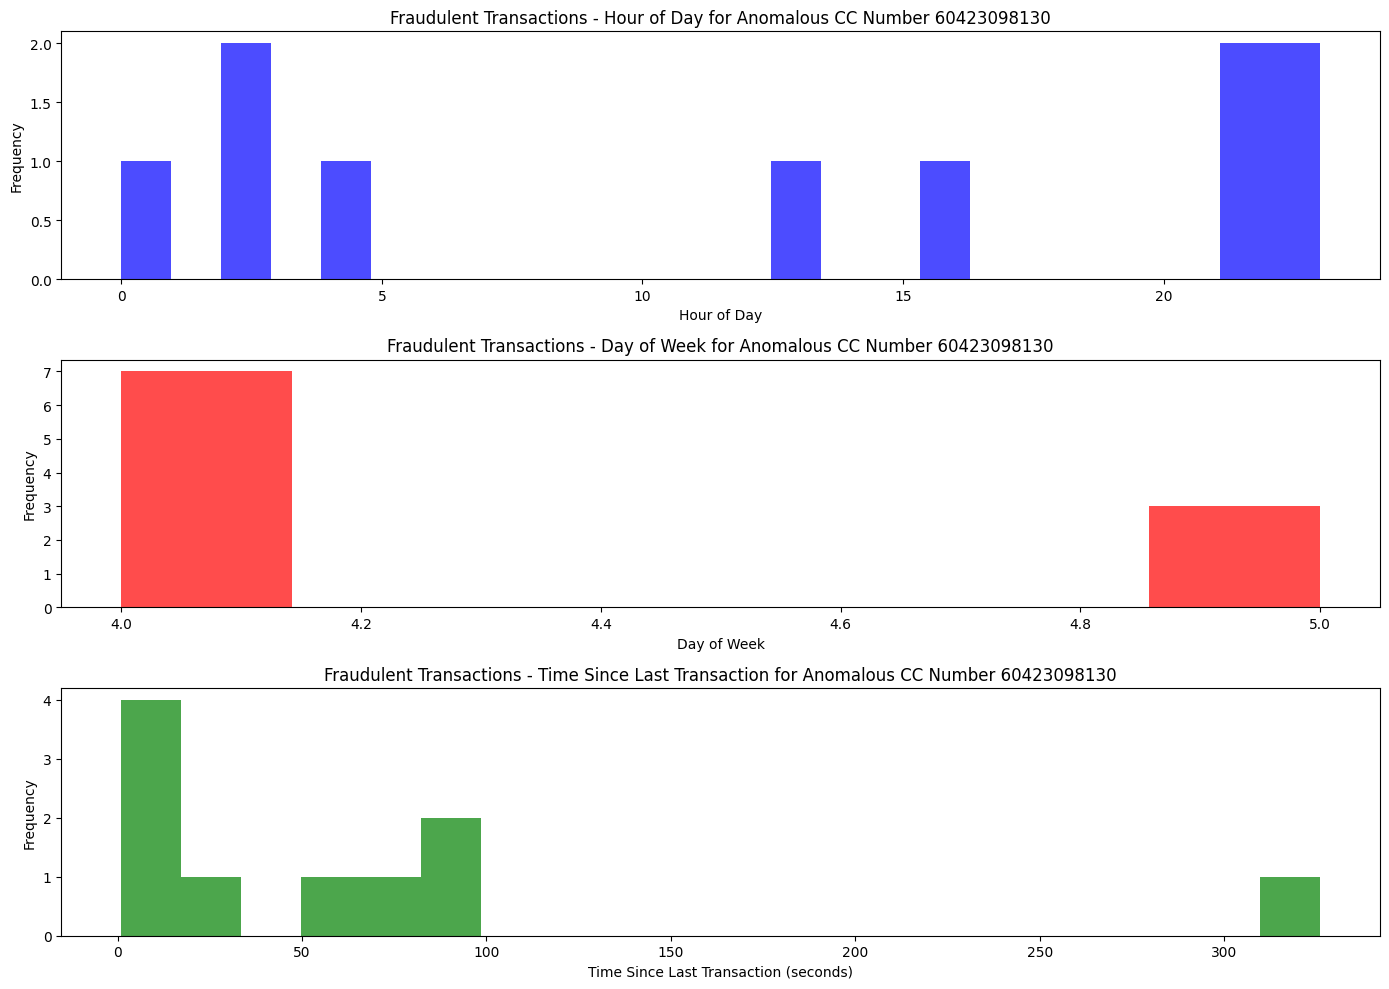

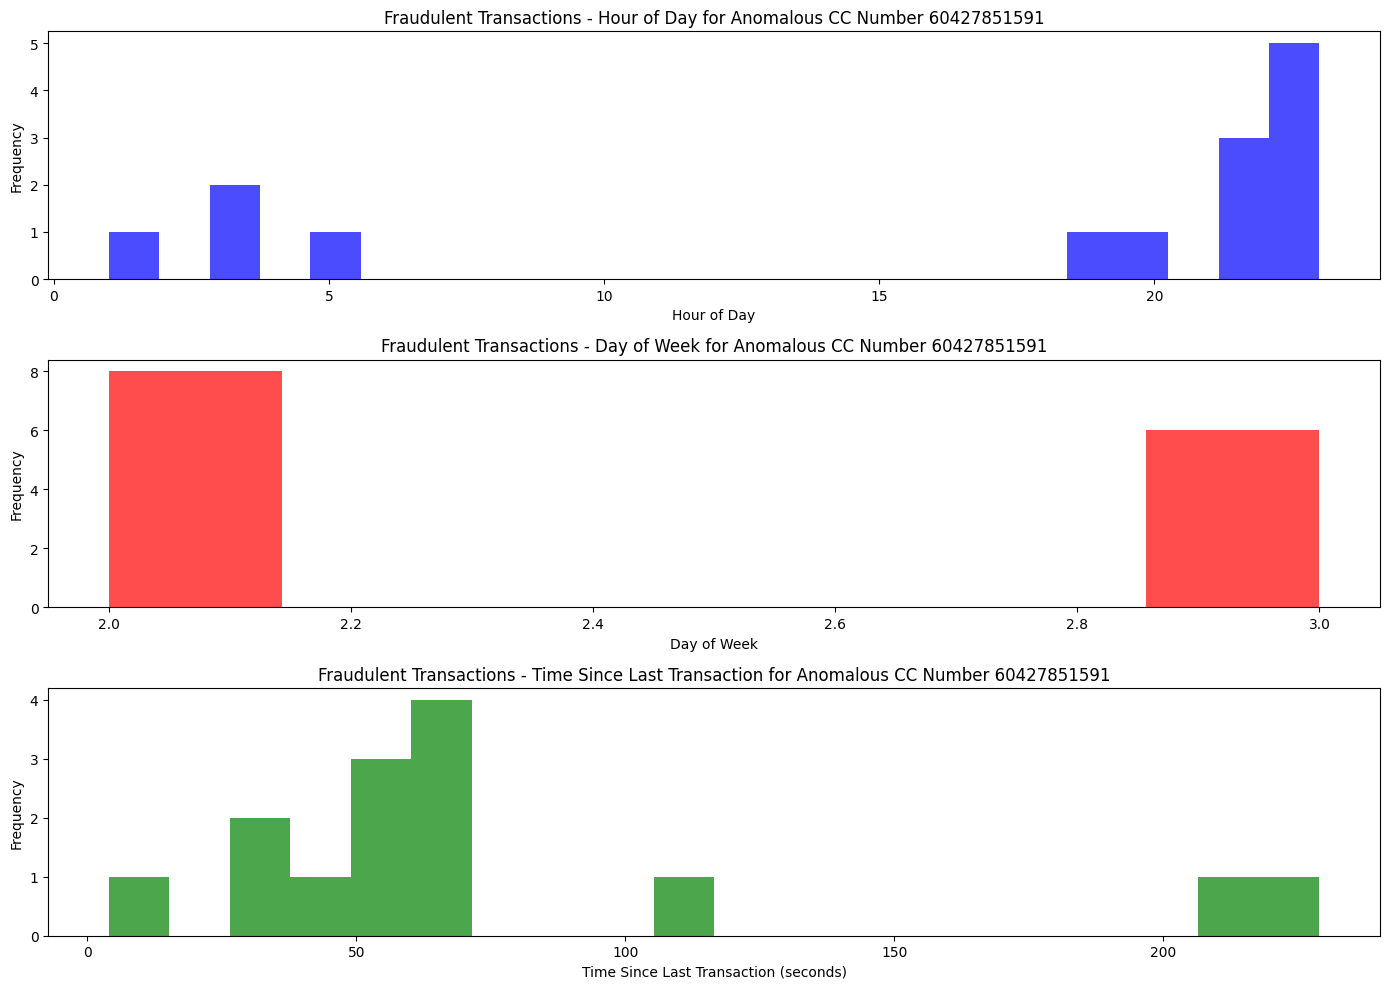

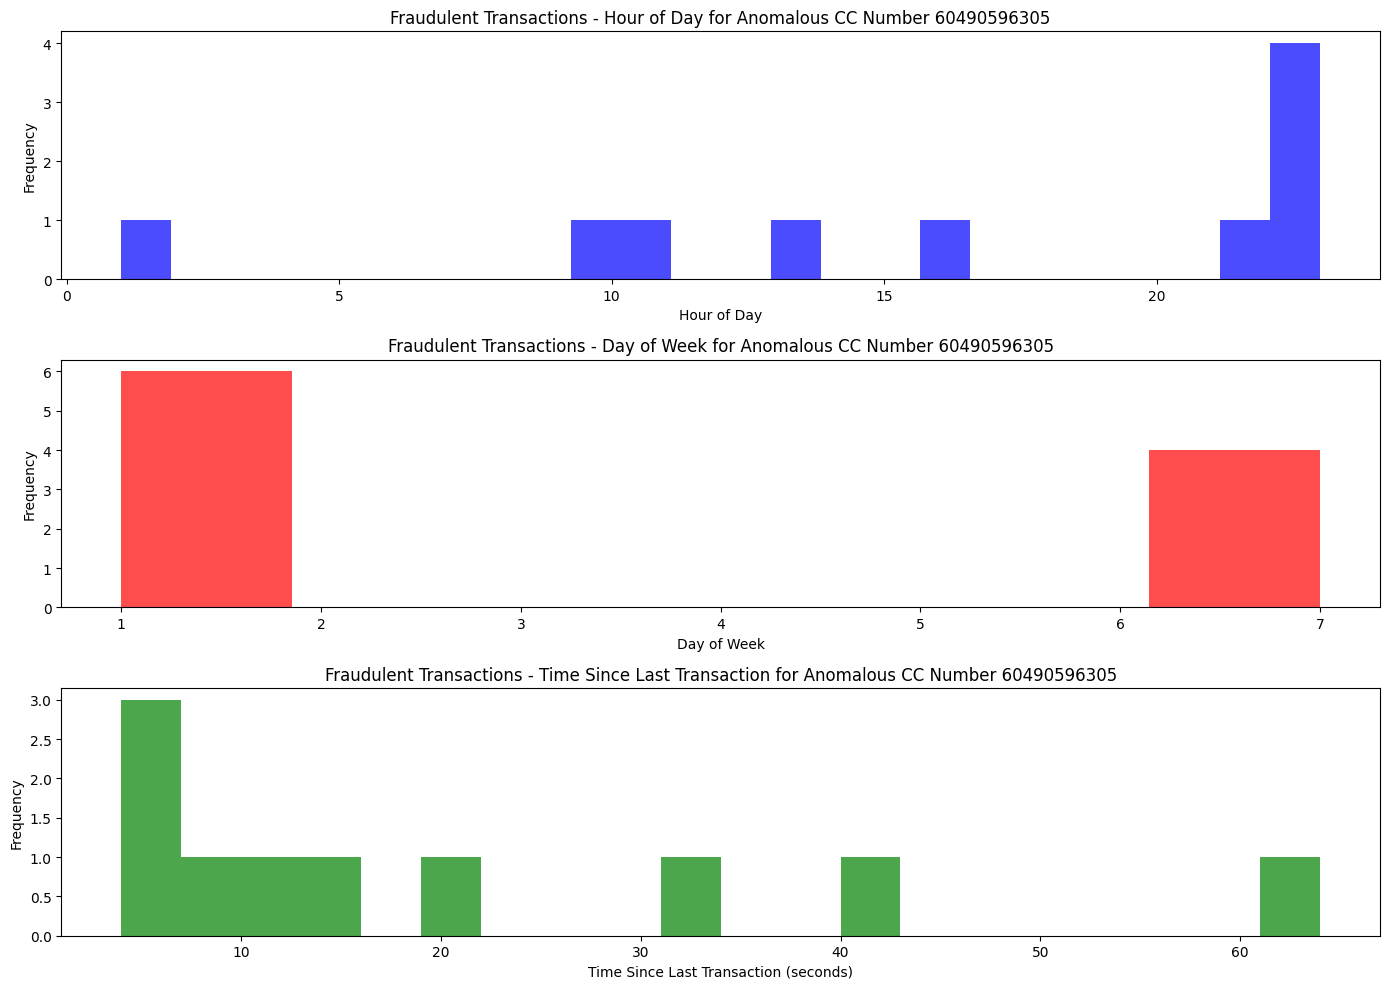

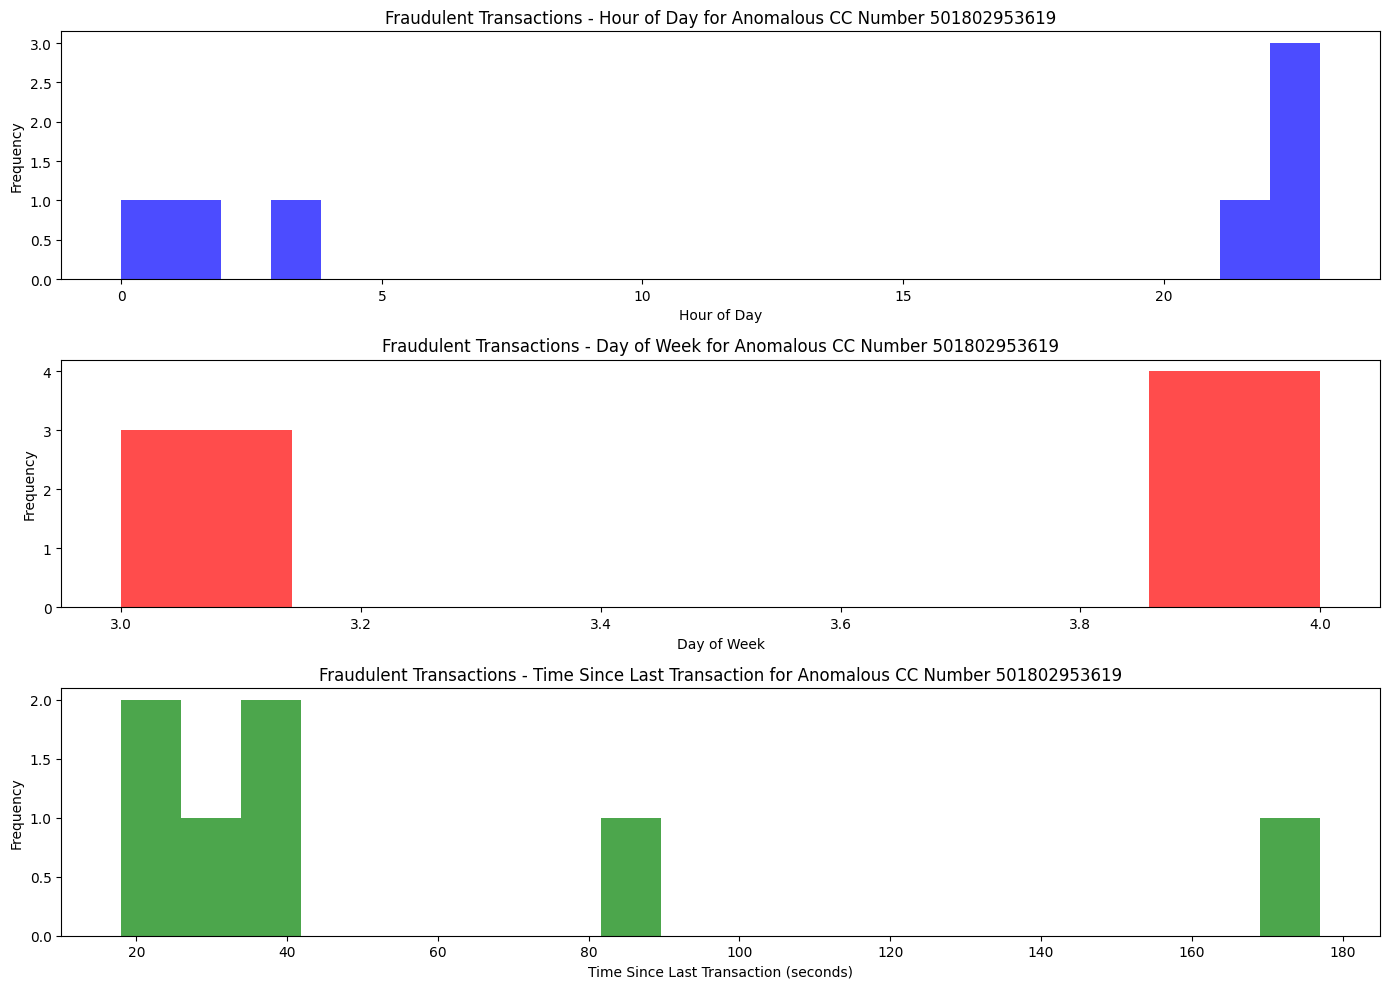

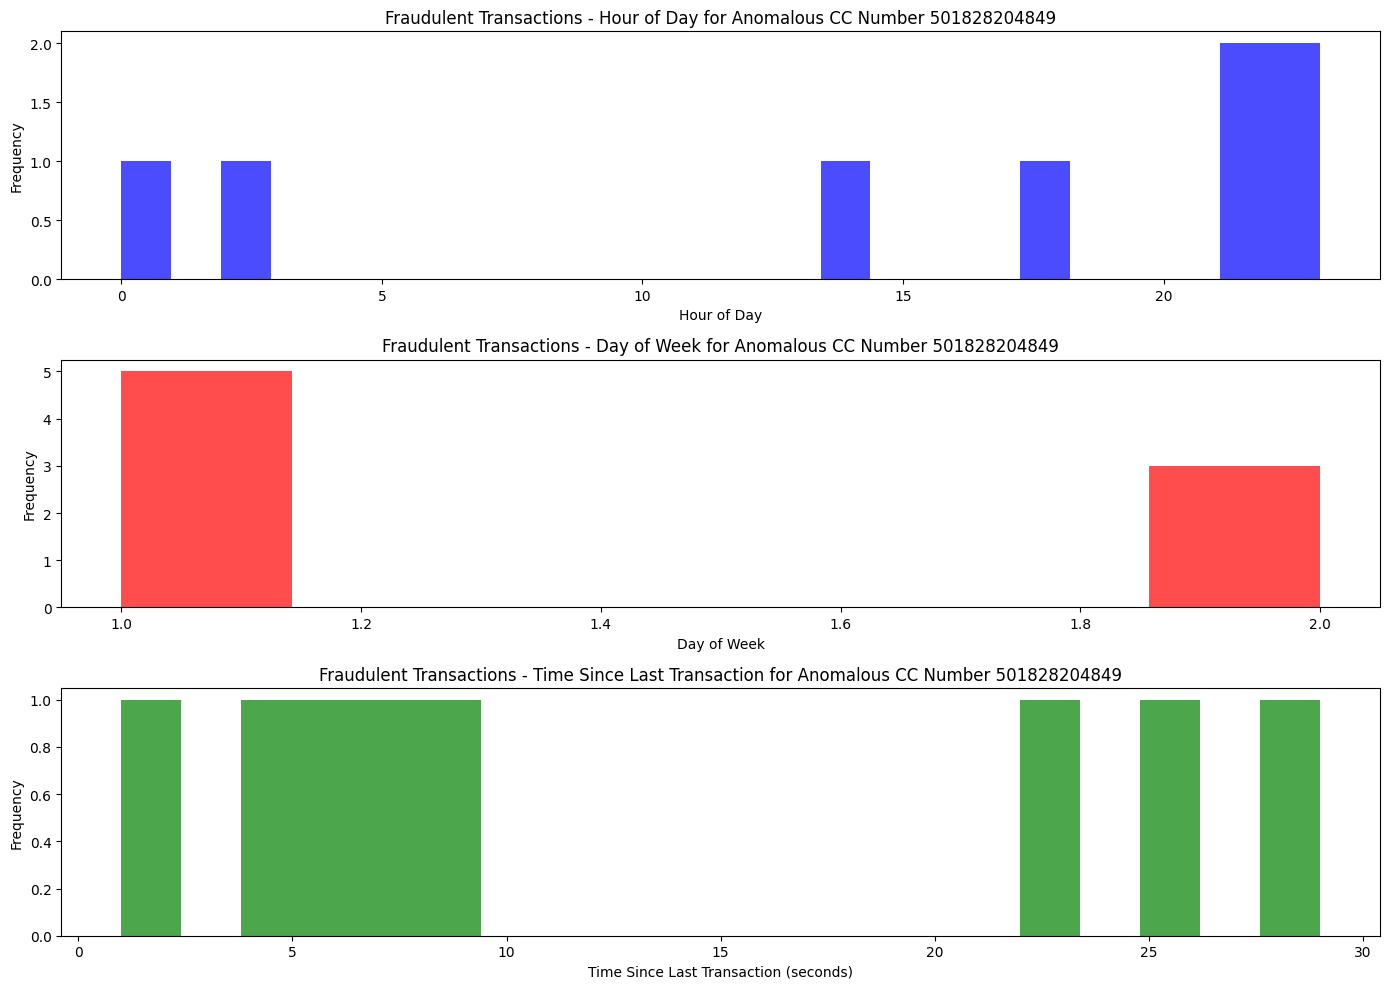

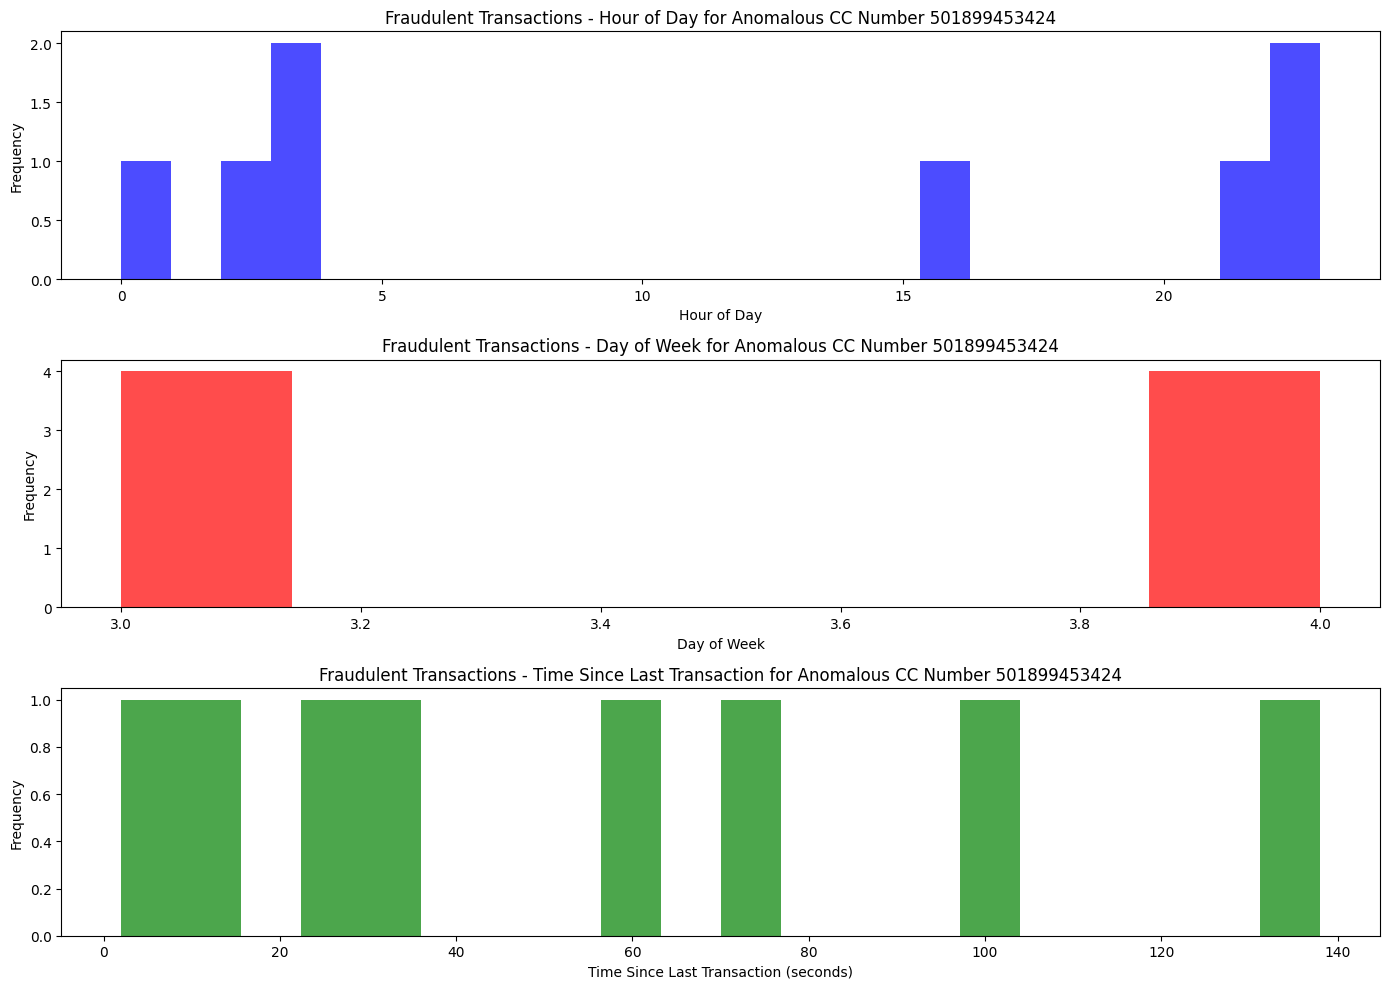

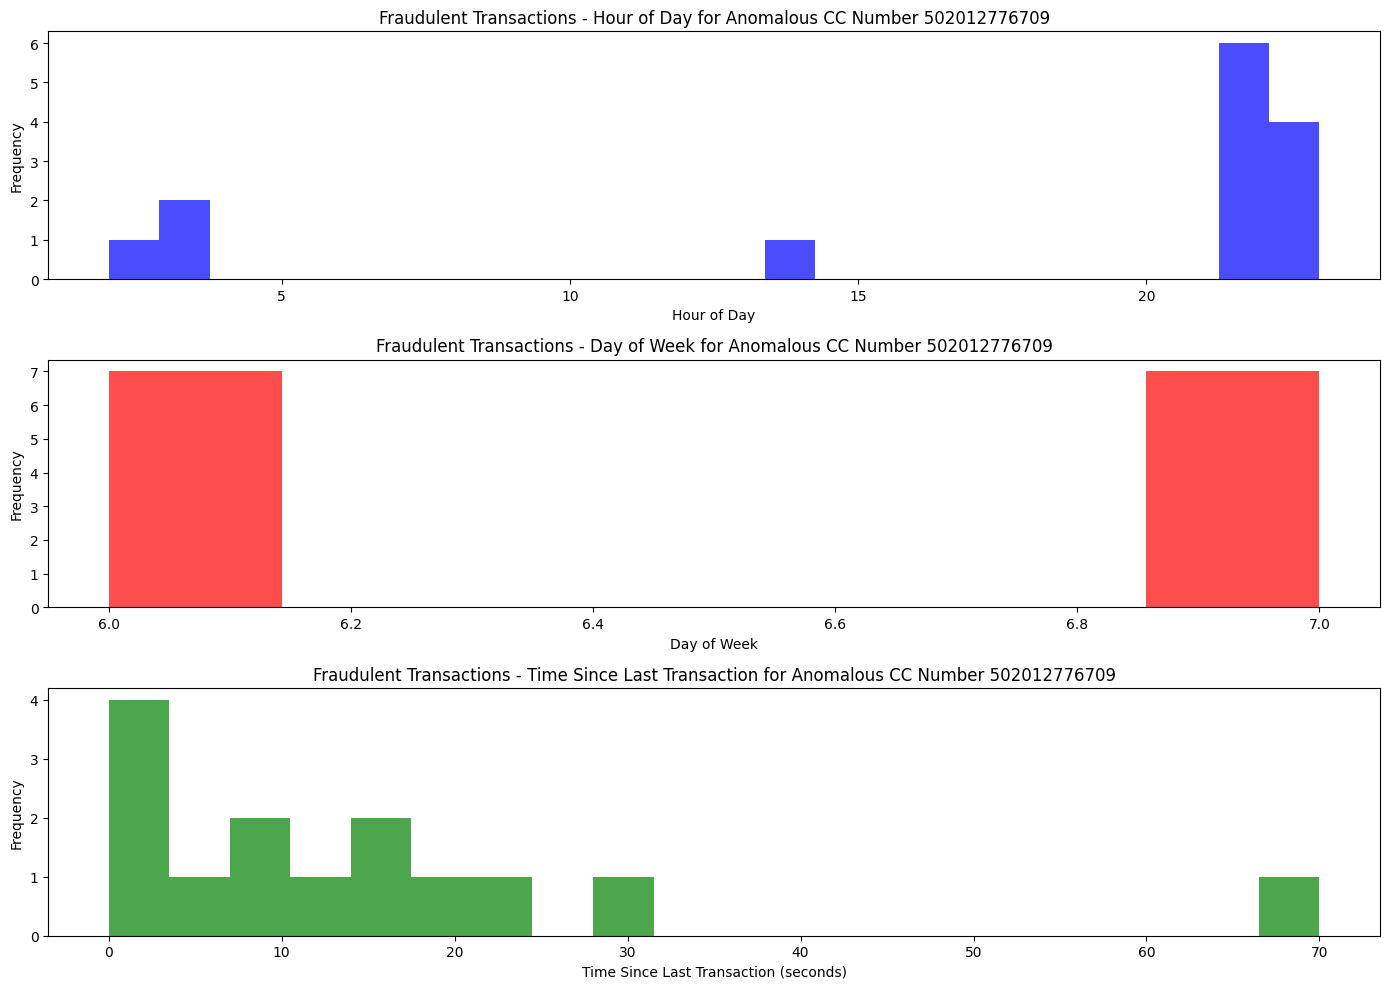

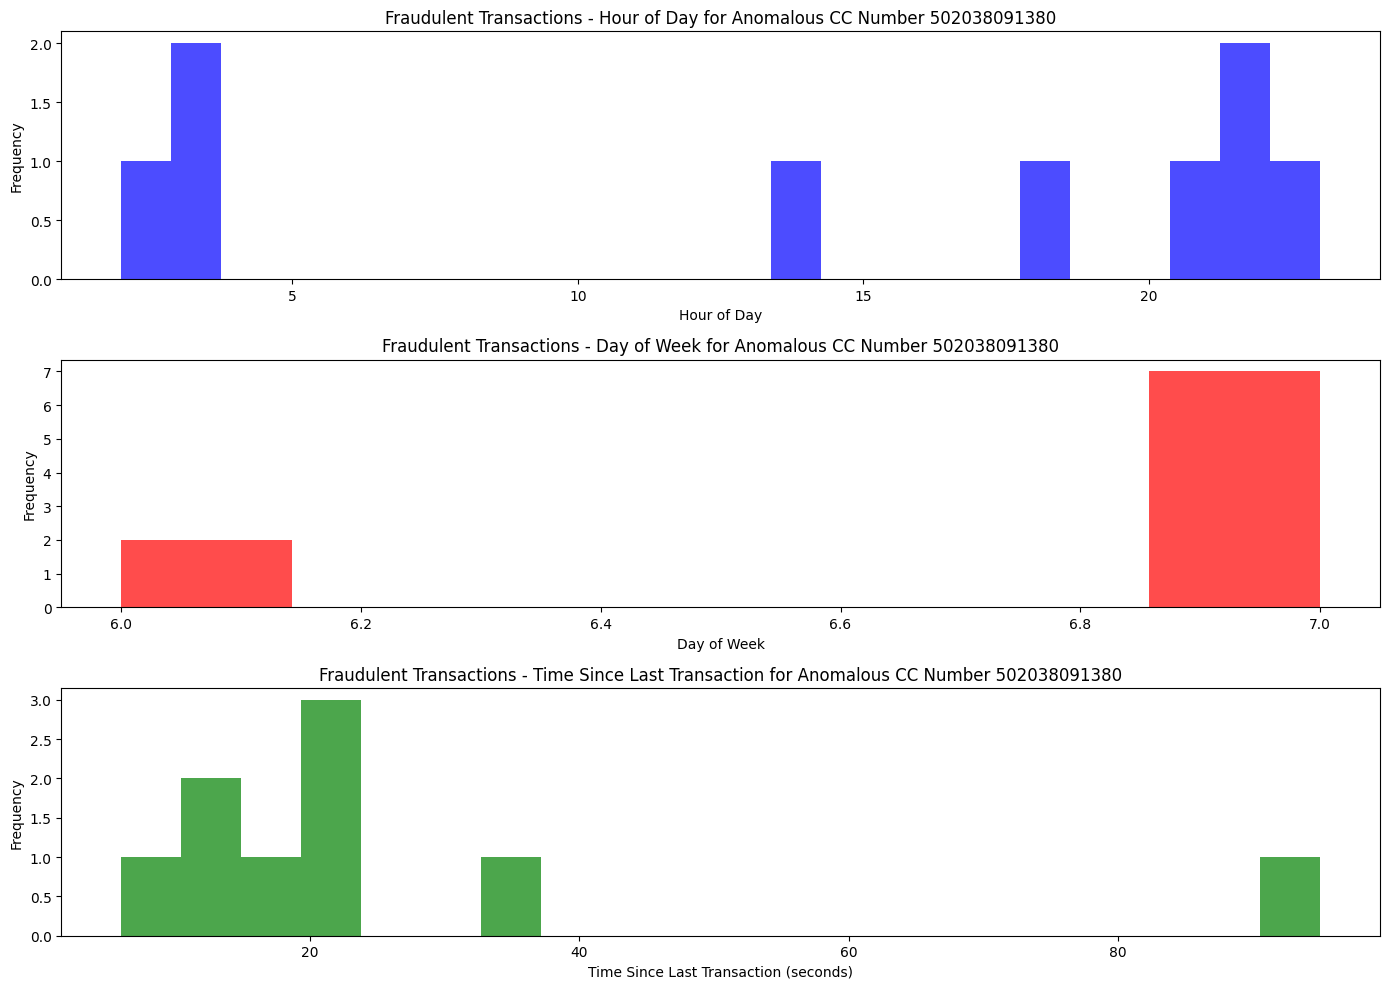

In [13]:
analyze_anomalous_transactions(result_df, data, n_samples=10)


**Top Chart: Hour of Day**
- Key Insights:
The fraudulent transactions are concentrated in two specific time frames: early hours around midnight and late evening between 8 PM and 10 PM.
Business Implication: These time frames may indicate higher vulnerability periods for this particular customer. The organization can use this data to implement stronger fraud monitoring or additional authentication measures during these peak hours.


**Bottom Chart: Day of Week**
- Key Insights:
Fraudulent transactions are more frequent mid-week and on weekends, with specific peaks possibly on Wednesday and Saturday.